In [1]:
from fastai.vision import *
from experiments import *
from dataset import *
from metrics import *
from config import *

%load_ext autoreload
%autoreload 2

pd.options.display.max_columns = 500

In [2]:
allData = getData()

In [6]:
MODEL_PATH = Path(EXPERIMENTS_PATH) / 'model' / 'resnet34'
for index, dataset in enumerate(getDatasets(allData, crop=False, cutInHalf = False)):
    if not (MODEL_PATH / str(index) / 'image predictions.csv').exists():
        random_seed(42)
        learn = load_learner(MODEL_PATH / str(index), 'final refined model 2.pkl')
        m = MetricsCallback(None)
        (MODEL_PATH / str(index) / 'predictions').mkdir(parents=True, exist_ok=True)  
        for idx in range(len(dataset.valid.x.items)):
            TENSOR_PATH = MODEL_PATH / str(index) / 'predictions' / (str(idx) + '.pt')
            if not (TENSOR_PATH).exists():
                pred = learn.predict(dataset.valid.x.get(idx, False))[2]
                torch.save(pred, TENSOR_PATH)
            else:
                pred = torch.load(TENSOR_PATH)
            m.on_train_begin()
            m.on_batch_end(False, pred, dataset.valid.y.get(idx, False).px)
            m.calculateMetrics()
            m.save(MODEL_PATH / str(index) / 'image predictions.csv', True)

In [4]:
df = pd.read_csv(MODEL_PATH / str(4) / 'image predictions.csv', index_col=False)

In [ ]:
df[df["hard #truth"] > 10].sort_values("global precision quantity %")[0:10]

In [4]:
def getData(folder, image):
    datasets = getDatasets(allData, crop=False, cutInHalf = False)
    dIndex, idx = findImage(datasets, folder, image)
    valid = datasets[dIndex].valid

    pred = torch.load(MODEL_PATH / str(dIndex) / 'predictions' / (str(idx) + '.pt'))
    pred = CustomImageSegment(torch.sigmoid(pred) > 0.5)

    x, y = valid.x.get(idx), valid.y.get(idx)
    
    return x, y, pred, valid, idx

def cutImages(imgs, cut):
    if cut is not None:
        for im in imgs:
            im.px = im.px[:, cut[0]:cut[1], cut[2]:cut[3]]

def show(x, y, predictions):
    for prediction in predictions:
        x.show(y = ImageSegment(colorizePrediction(prediction.px, y.px)), figsize=(22, 22), alpha=0.9)
            
def compare(folder, image, cut = None, mode = "relaxed"):
    x, y, pred, valid, idx = getData(folder, image)
    yu, xception, sickzil = valid.y.yu45020Image(idx), valid.y.xceptionImage(idx), valid.y.sickzilImage(idx)
    
    cutImages([x, y, yu, xception, sickzil, pred], cut)
        
    x.show(figsize=(22, 22))
    y.original.rgb.show(figsize=(22, 22))
    y.rgb.show(figsize=(22, 22))
    
    if mode != "relaxed":
        y = y.original
    
    show(x, y, [yu, xception, sickzil, pred])

In [ ]:
compare("TouyouKidan", 0)

In [ ]:
compare("BEMADER_P", 6, (620, 1090, 900, 1580))

In [ ]:
compare("BEMADER_P", 6, (620, 1090, 900, 1580), "normal")

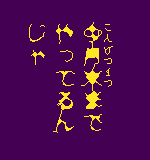

In [4]:
dataset = getDatasets(allData, crop=False, cutInHalf = False)[0]
idx = 42
ImageSegment(dataset.valid.y.get(idx).eroded.px[:, 170:330, 250:400])

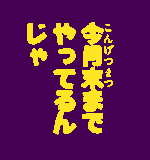

In [5]:
ImageSegment(dataset.valid.y.get(idx).original.px[:, 170:330, 250:400])

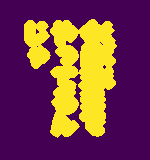

In [6]:
ImageSegment(dataset.valid.y.get(idx).px[:, 170:330, 250:400] != 0)

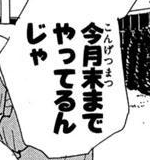

In [14]:
Image(dataset.valid.x.get(idx).px[:, 170:330, 250:400])

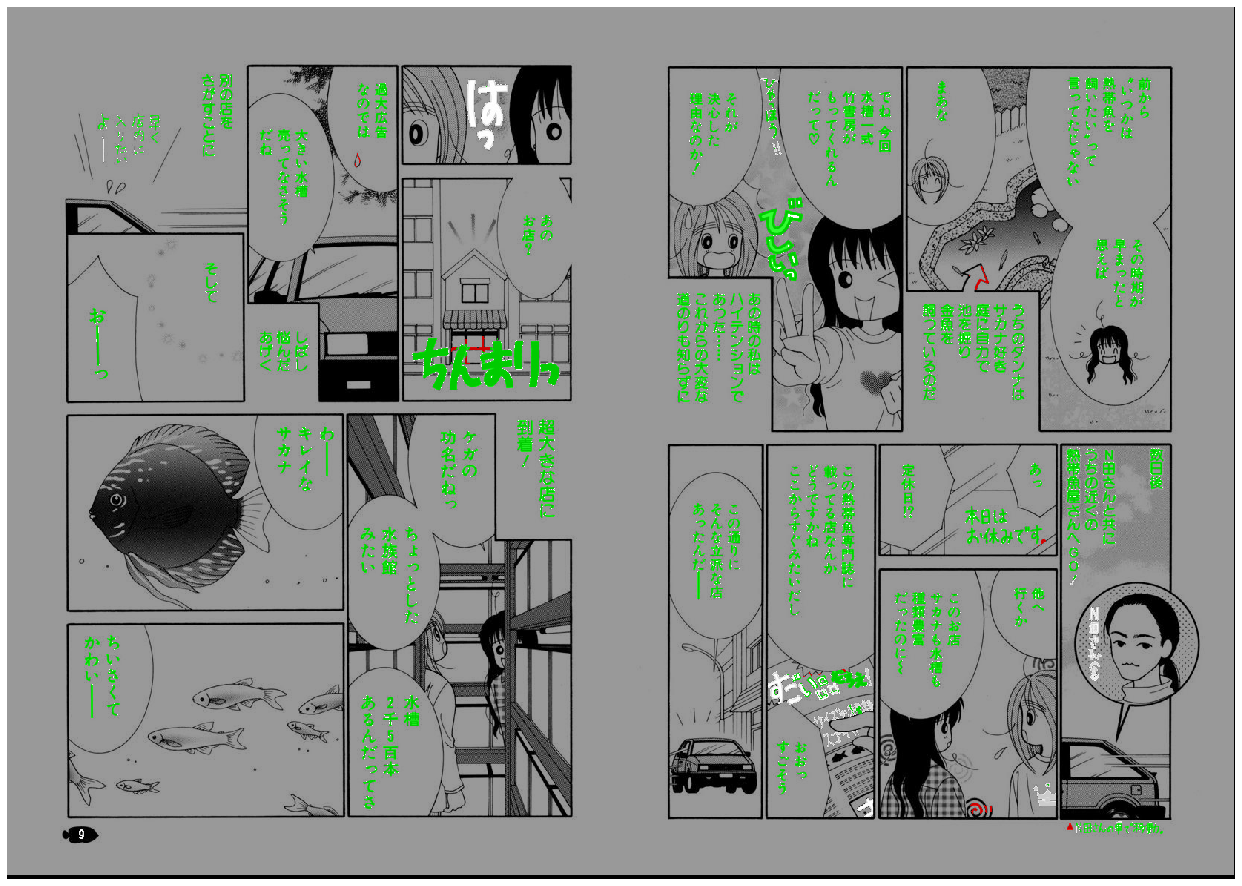

In [28]:
x, y, pred, valid, idx = getData("EverydayOsakanaChan", 3)
x.show(y = ImageSegment(colorizePrediction(pred.px, y.px)), figsize=(22, 22), alpha = 0.8)

In [71]:
iters = range(1, 6)

for index, dataset in enumerate(getDatasets(allData, crop=False, cutInHalf = False)):
    m = dict()
    for iterations in iters:
        m[iterations] = MetricsCallback(None)
        m[iterations].on_train_begin()    
    
    for idx in range(len(dataset.valid.x)):
        pred = torch.load(MODEL_PATH / str(index) / 'predictions' / (str(idx) + '.pt'))
        pred = torch.sigmoid(pred) > 0.5
        for iterations in iters:
            p = pred[0].numpy().copy()
            for i in range(iterations):
                p = binary_dilation(p)
            m[iterations].on_batch_end(False, tensor(p).unsqueeze(0), dataset.valid.y[idx].px)       
    for iterations in iters:
        m[iterations].calculateMetrics() 
        m[iterations].save(MODEL_PATH / ('dilated predictions ' + str(iterations) + '.csv'), True)

In [ ]:
iters = range(1, 6)
for it in iters:
    row = pd.read_csv(MODEL_PATH / ('dilated predictions ' + str(it) + '.csv'))
    printStats(row, str(it))

In [38]:
for index, dataset in enumerate(getDatasets(allData, crop=False, cutInHalf = False)):
    for idx in range(len(dataset.valid.y.items)):
        path = Path(dataset.valid.y.items[idx])
        newPath = ("/".join(("",) + path.parts[1:3] + ('manga-cached',) + path.parts[4:]))
        im = Im.fromarray(image2np(dataset.valid.y.get(idx, False).original.rgb.px * 255).astype(np.uint8))
        os.makedirs(os.path.dirname(newPath), exist_ok=True)
        im.save(newPath, format='PNG')